In [330]:
import math
import numpy as np
from graphviz import Digraph
from activation_functions import activations as act
global exp

In [331]:
exp = math.e

In [332]:
#GraphViz functionality
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [333]:
class Value():
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        # other = other if isinstance(other, Value) else Value(other)
        # out = Value(self.data + (-other.data),(self,other),'-')
        # return out
        return self + (-other)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
       # other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        #e^2x -1/e^2x + 1
        top = exp**(2*self.data) - 1
        bot = exp**(2*self.data) + 1
        tanh = top/bot
        out = Value(tanh,(self,),'tanh')
        
        def _backward():
            self.grad += (1-tanh**2) * out.grad
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
            
        def _backward():
            self.grad += (out.grad > 0) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

### The basic neural network can be represented as
## $$ \hat{y} = \sum(w_i.x_i) + bias$$
#### Where
#### x is the input feature
#### w is the respective weight for the input feature
#### b is the added bias
#### tanh is the activation function to add non linearity

In [334]:
x1 = Value(2.0,label='x1')
x2 = Value(3.0,label='x2')
w1 = Value(10.0,label='w1')
w2 = Value(-9.1999999999,label='w2')
b = Value(6.881313,label='b')

In [335]:
w1x1 = w1 * x1
w1x1.label = 'w1*x1'

In [336]:
w2x2 = w2 * x2
w2x2.label = 'w2*x2'

In [337]:
wsum = w1x1 + w2x2
wsum.label = 'sum'

In [338]:
pre = wsum + b
pre.label = 'bias'

In [339]:
y_hat = pre.tanh()
y_hat.label = 'yhat'

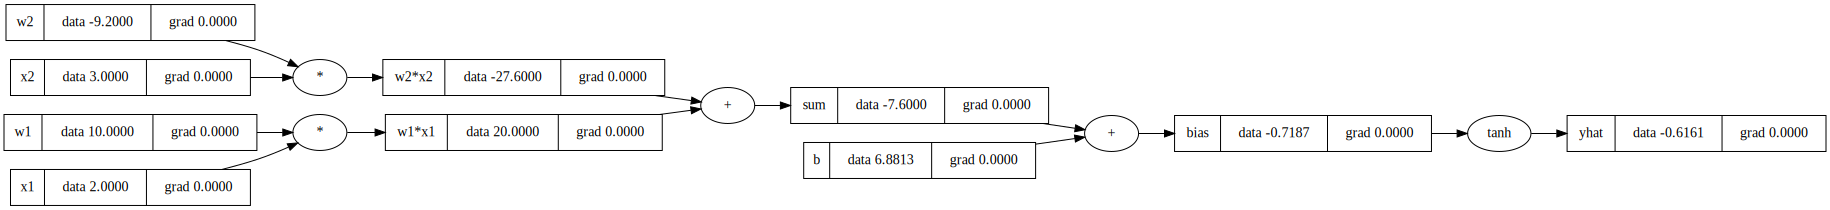

In [340]:
draw_dot(y_hat)

In [341]:
y_hat.backward()

In [342]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []
    
class Neuron(Module):
    def __init__(self,nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self,x):
        # w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP(Module):
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [343]:
model = MLP(3,[4,4,1])

In [344]:
#Define the inputs and the targets
xs=[
    [2.0,3.0,-1.0],
    [3.0,3.0,4.0],
    [4.0,2.0,1.5],
    [5.5,3.5,2.5]
    ]
ys = [1.0,-1.0,-1.0,1.0]
# ys = [Value(x) for x in ys]

In [345]:
def loss(batch_size=None):
    total_loss = Value(0.0)
    #Convert the inputs into Value Object
    inputs = [list(map(Value, xrow)) for xrow in xs]
    
    #forward the model to get the scores
    scores = list(map(model,inputs))
    
#     # svm "max-margin" loss
#     losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(ys, scores)]
#     data_loss = sum(losses) * (1.0 / len(losses))
#     # L2 regularization
#     alpha = 1e-4
#     reg_loss = alpha * sum((p*p for p in model.parameters()))
#     total_loss = data_loss + reg_loss
    
#     # also get accuracy
#     accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(ys, scores)]
#     return total_loss, sum(accuracy) / len(accuracy)
    
    # Calculate Losses and sum them up
    losses = [(yout-ygt)**2 for ygt,yout in zip(ys,scores)]
    for loss in losses:
        print(loss)
        total_loss += loss
    
    return total_loss
    
    #Calculate Accuracy
#     accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(ys, scores)]
#     for yi, scorei in zip(ys,scores):
#         print(str(yi) + '==>' + str(scorei))

    
#     return total_loss,sum(accuracy)/len(accuracy)

In [346]:
for k in range(10):
    #Forward
    #total_loss,acc = loss()
    total_loss = loss()
    
    #Backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data += -(learning_rate) * p.grad
    
    print(f"step {k} loss {total_loss}")#, accuracy {acc*100}%")

step 0 loss Value(4.335478200309733)
step 1 loss Value(4.295764927743988)
step 2 loss Value(7.999709512640855)
step 3 loss Value(7.999707886327138)
step 4 loss Value(7.999706256790782)
step 5 loss Value(7.999704624231089)
step 6 loss Value(7.9997029888528095)
step 7 loss Value(7.999701350866183)
step 8 loss Value(7.9996997104869925)
step 9 loss Value(7.9996980679365945)
